In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
import time

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)

# Model settings
supervised = True
if supervised == True:
    model_name = f"supervised_pinn"
else:
    model_name = f"unsupervised_pinn"
# Experiment settings
k = 200 # spring constant (N/m)
c = 2 # damping constant (N.s/m)
m = 1 # load mass (kg)
# F = 0 # external force (N)
t0 = 0.0 # initial time (sec)
tt = 3.0 # final time (sec)

def exact_function(t):
    d = c / (2 * m)
    w0 = np.sqrt(k / m)

    # x(t) = exp^(-d * t) * (2A * cos(phi + w * t))
    w = np.sqrt((w0**2)-(d**2))
    phi = np.arctan(-d/w)
    A = 1 / (2 * np.cos(phi))
    x = (np.exp(-d * t)) * (2 * A * np.cos(phi + w * t))
    return x

t_test = torch.linspace(t0, tt, 1200).view(-1, 1).requires_grad_(True)
x_test = torch.tensor(exact_function(t_test.detach().numpy())).view(-1, 1).requires_grad_(True)

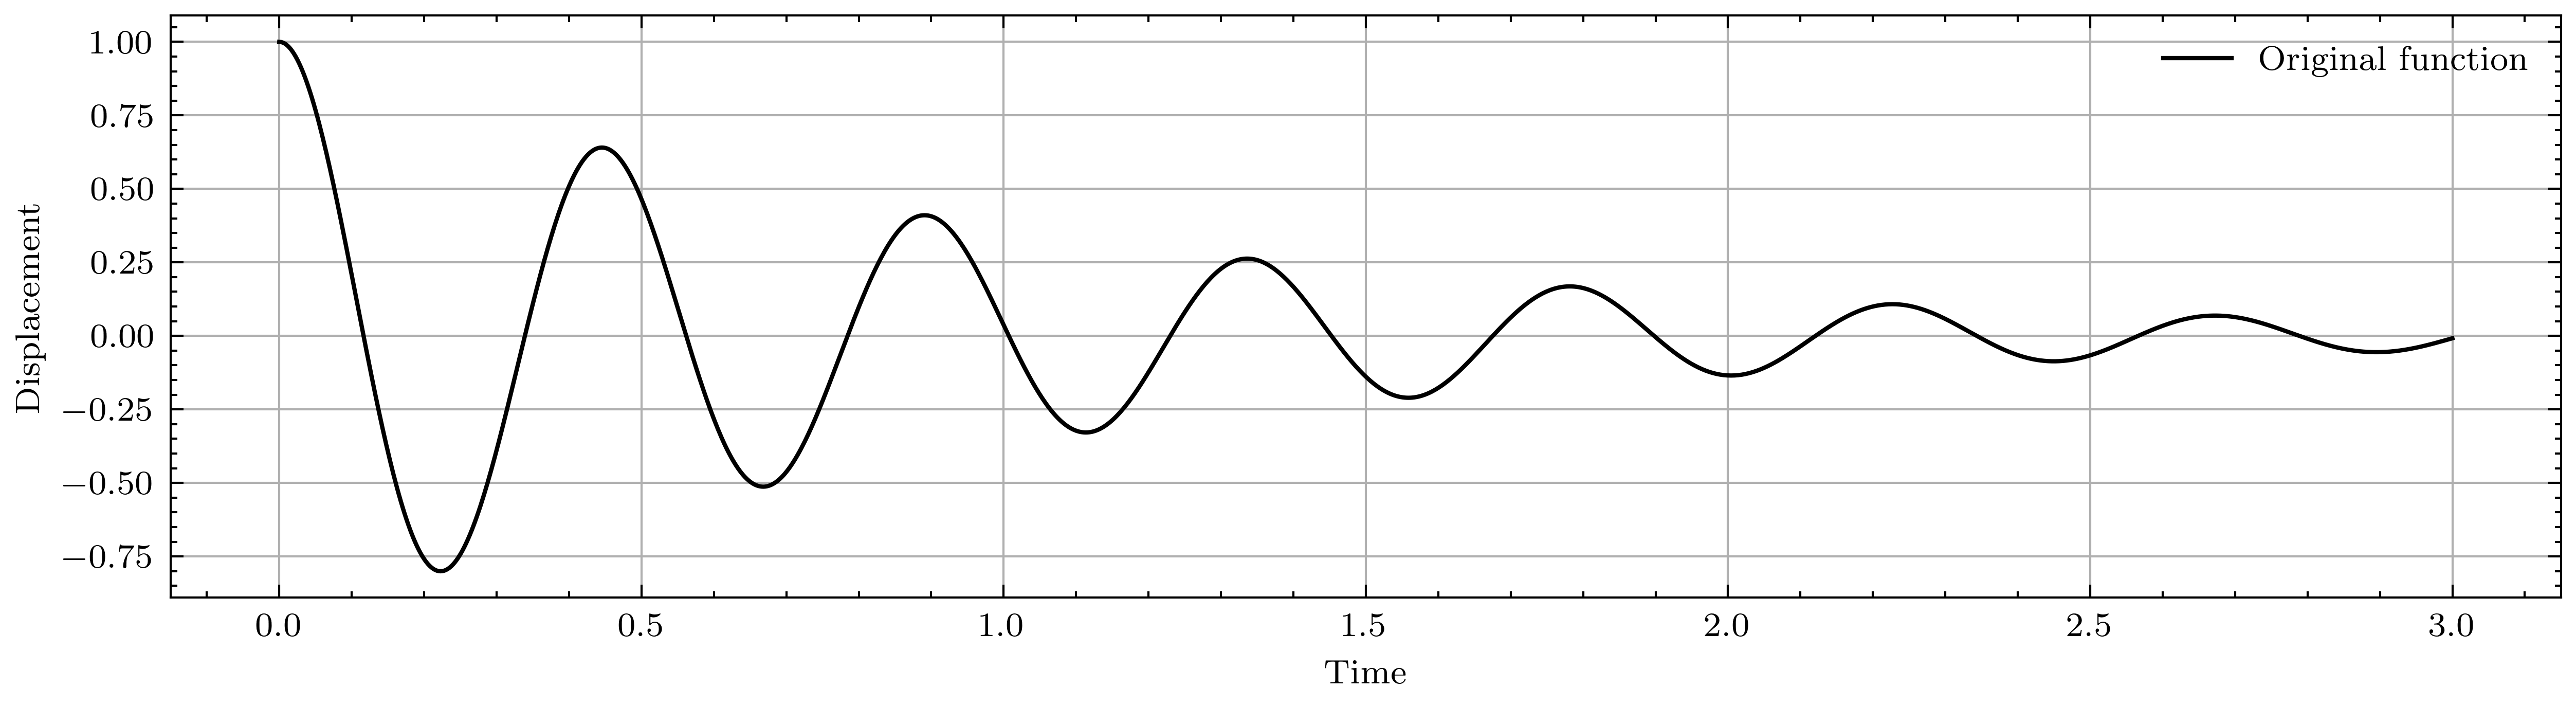

In [2]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
# plt.savefig("../figures/pinn/problem_statement.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
# Define the neural network model
class FCNN(nn.Module):
    '''
    Define neural network architecture
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN), activation()
        ])
        
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN), activation()
            ]) for _ in range(N_LAYERS)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


model = FCNN(1, 1, 32, 8)

model_path = f"../../model/{model_name}.pt"
model.load_state_dict(torch.load(model_path))
print(f"Model: {model_name} loaded!")
model.eval()
predictions = model(t_test)

Model: supervised_pinn loaded!


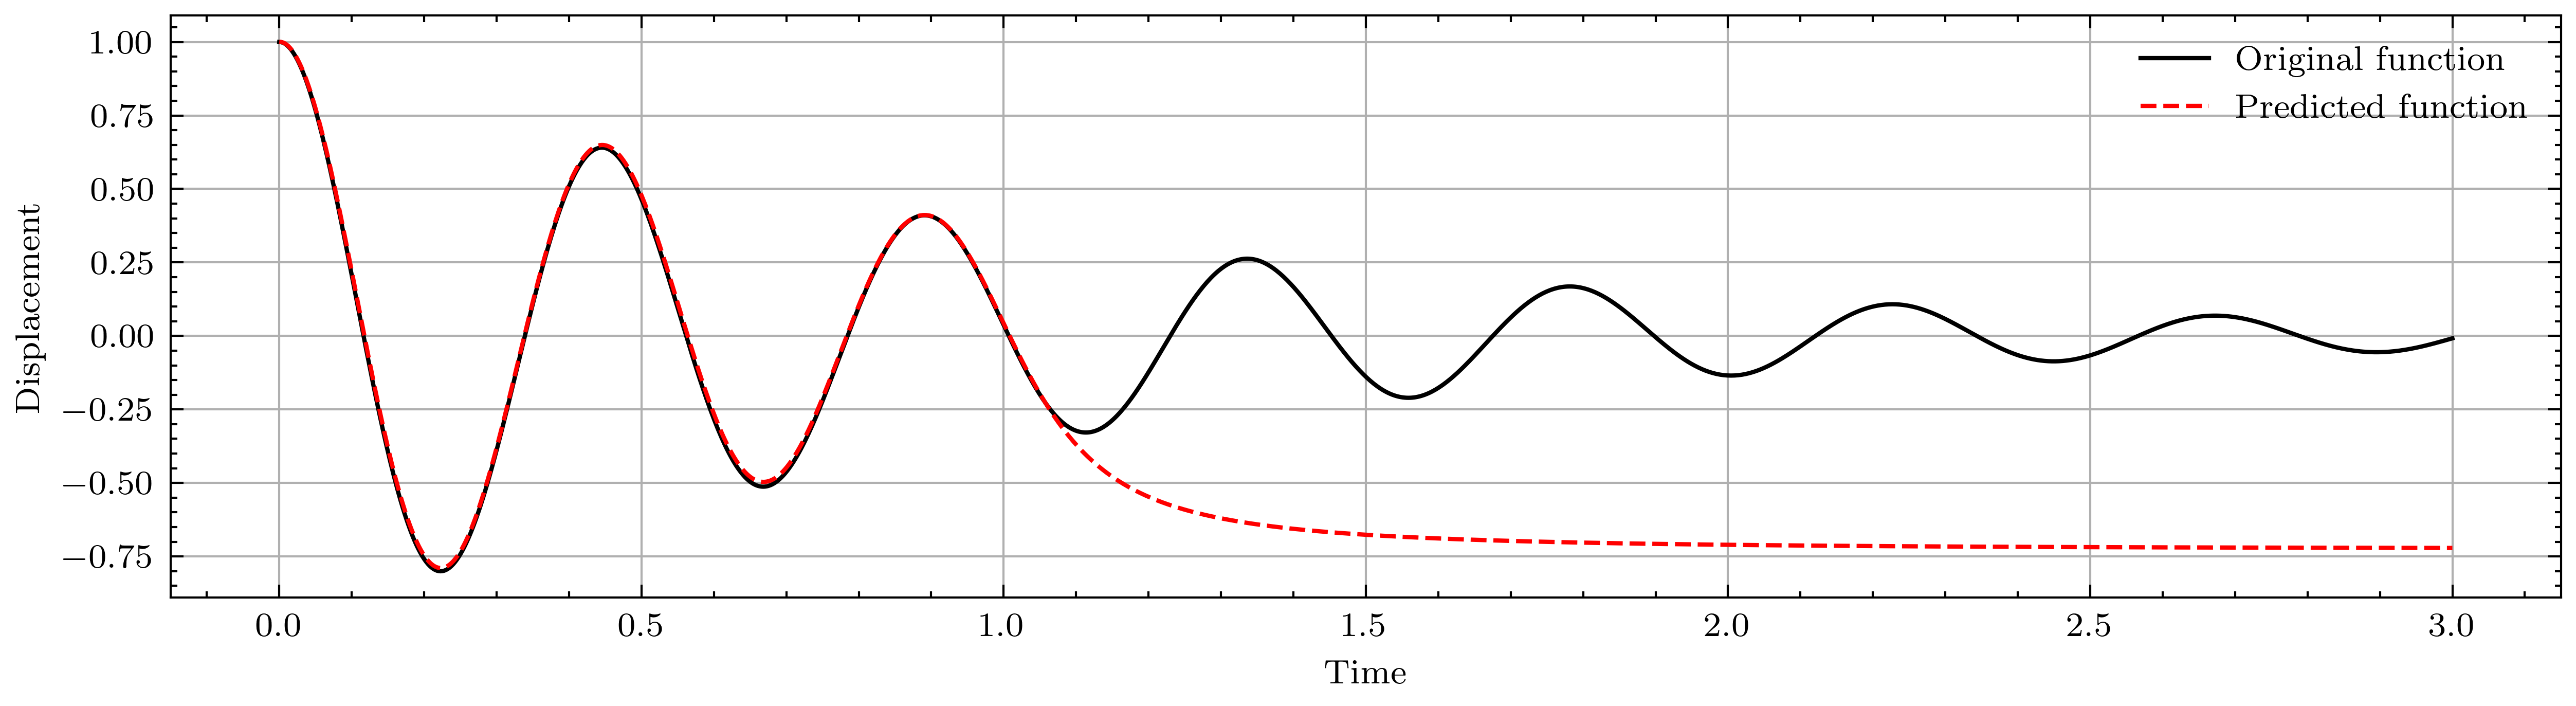

In [4]:
# Plot the original function and the predicted function
fig, ax = plt.subplots(figsize=(10, 2.5))
ax.plot(t_test.detach().numpy(), x_test.detach().numpy(), label='Original function')
ax.plot(t_test.detach().numpy(), predictions.detach().numpy(), label='Predicted function', color='red')
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
plt.grid()
plt.legend()
# plt.savefig("../figures/pinn/sup_final.svg", format='svg', dpi=300, bbox_inches='tight')
plt.show()